In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle competitions download -c you-are-bot

In [3]:
!unzip you-are-bot.zip -d dataset-folder

Archive:  you-are-bot.zip
  inflating: dataset-folder/sample_submission.csv  
  inflating: dataset-folder/test.json  
  inflating: dataset-folder/train.json  
  inflating: dataset-folder/ytest.csv  
  inflating: dataset-folder/ytrain.csv  


In [4]:
from torch.utils.data import TensorDataset, DataLoader
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.ensemble import RandomForestClassifier
import transformers
import torch
import copy
from torch import nn
from typing import Union, Dict, List, Optional, Any
import torch
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def load_train_data(data_file: str, labels_file: str):
    all_texts = []
    all_labels = []

    labels_df = pd.read_csv(labels_file)
    labels_df = labels_df[labels_df["participant_index"] == 0]
    labels_dict = dict(zip(labels_df["dialog_id"], labels_df["is_bot"]))

    with open(data_file, "r", encoding="utf-8") as f:

        data = json.load(f)
        for key in data.keys():
            messages = data[key]

            part_0_texts = [
                m["text"] for m in messages if m["participant_index"] == "0"
            ]
            part_1_texts = [
                m["text"] for m in messages if m["participant_index"] == "1"
            ]

            part_0_label = int(labels_dict[key])
            part_1_label = 1 - part_0_label

            text_0 = " ".join(part_0_texts)
            text_1 = " ".join(part_1_texts)

            all_texts.append(text_0)
            all_labels.append(part_0_label)

            all_texts.append(text_1)
            all_labels.append(part_1_label)

    df = pd.DataFrame({"text": all_texts, "is_bot": all_labels})
    return df


def load_test_data(data_file: str, labels_file: str):
    df_info = pd.read_csv(labels_file)

    with open(data_file, "r", encoding="utf-8") as f:
        data = json.load(f)

    all_texts = []
    ids = []

    for _, row in df_info.iterrows():
        dialog_id = row["dialog_id"]
        participant_index = str(row["participant_index"])
        messages = data[dialog_id]

        texts = [
            m["text"] for m in messages if m["participant_index"] == participant_index
        ]
        combined_text = " ".join(texts)
        all_texts.append(combined_text)
        ids.append(row["ID"])

    df = pd.DataFrame({"ID": ids, "text": all_texts})
    return df

In [6]:
df_test = load_test_data("/content/dataset-folder/test.json", "/content/dataset-folder/ytest.csv")


In [7]:
df = load_train_data("/content/dataset-folder/train.json", "/content/dataset-folder/ytrain.csv")
df

,text,is_bot
0,Hello! Отлично! А твои? Расскажи теорему,0
1,Как дела? Это круто!,1
2,Привет никак оооокккееуу оууукккии оооуууллкке...,0
3,Привет! Как я могу помочь тебе сегодня? Хорошо...,1
4,Привет Ты бот?,0
...,...,...
1567,"привет, как дела? ну, нормально, а у тебя? хз,...",1
1568,привет 🇬🇳 АХАХАХХАХА,0
1569,гойда данил иди нах придурок,1
1570,где что когда почему 20 04 как где сколько теб...,0


In [8]:
print("Размер датасета:", df.shape)
print("Распределение меток:\n", df["is_bot"].value_counts())
print("Пропуски:\n", df.isnull().sum())
print("Дубликаты:", df.duplicated().sum())

Размер датасета: (1572, 2)
Распределение меток:
 is_bot
0    786
1    786
Name: count, dtype: int64
Пропуски:
 text      0
is_bot    0
dtype: int64
Дубликаты: 6


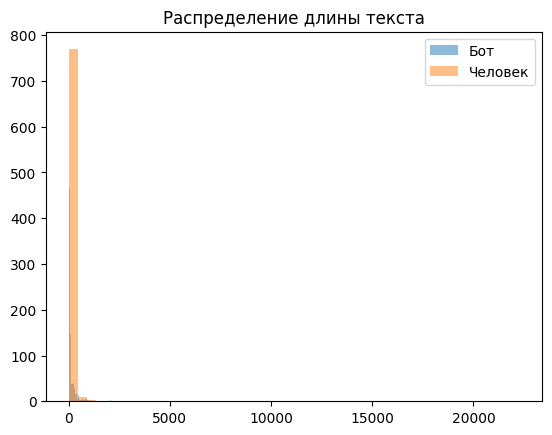

In [9]:
df["text_length"] = df["text"].apply(len)
df["word_count"] = df["text"].apply(lambda x: len(x.split()))

plt.hist(df[df["is_bot"] == 1]["text_length"], alpha=0.5, label="Бот", bins=50)
plt.hist(df[df["is_bot"] == 0]["text_length"], alpha=0.5, label="Человек", bins=50)
plt.legend()
plt.title("Распределение длины текста")
plt.show()

In [10]:
# Топ-5 самых длинных текстов у людей
longest_human_texts = df[df["is_bot"] == 0].nlargest(5, "text_length")["text"]
for text in longest_human_texts:
    print(f"Длина: {len(text)}, Текст: {text[:200]}...")  # Выводим первые 200 символов

Длина: 22279, Текст: 
Найти тему
Главная
Подписки
Найти тему
Видео
Статьи
Ролики
Новости
Сохранённое
Видеоигры
Детям
Всё о Дзене
Вакансии
Дзен на 
iOS и Android

Ещё
Кибер на Спортсе
27,7 тыс подписчиков
Подписаться
Сущес...
Длина: 11207, Текст: hu fjidsojfdiosfjiosdjfdiosfjidsojfdiosfjiosdjfdiosfjidsojfdiosfjiosdjfdiosfjidsojfdiosfjiosdjfdiosfjidsojfdiosfjiosdjfdiosfjidsojfdiosfjiosdjfdiosfjidsojfdiosfjiosdjfdiosfjidsojfdiosfjiosdjfdiosfjids...
Длина: 2071, Текст: Пиво — это алкогольный напиток, который производится путем брожения зерновых культур, чаще всего ячменя, с добавлением воды, хмеля и дрожжей. Пиво является одним из старейших напитков, известных челов...
Длина: 1366, Текст: hey Привет! Как я могу помочь? Если у вас есть вопросы или темы, которые вас интересуют, я готов помочь. Расскажите, чем я могу быть полезен? Конечно, вот простой рецепт жареных кабачков:

### Жареные...
Длина: 1242, Текст: hey Привет! Как дела? Чем могу помочь сегодня? Если у тебя есть вопросы или темы, 

In [11]:
print(df["text_length"].describe())

count     1572.000000
mean       130.994911
std        665.477772
min          3.000000
25%         29.000000
50%         49.000000
75%         87.000000
max      22279.000000
Name: text_length, dtype: float64


In [12]:
data_clean = df[df["text_length"] <= 500].copy()

In [13]:
print(data_clean["text_length"].describe())

count    1513.000000
mean       75.051553
std        82.626126
min         3.000000
25%        29.000000
50%        47.000000
75%        82.000000
max       495.000000
Name: text_length, dtype: float64


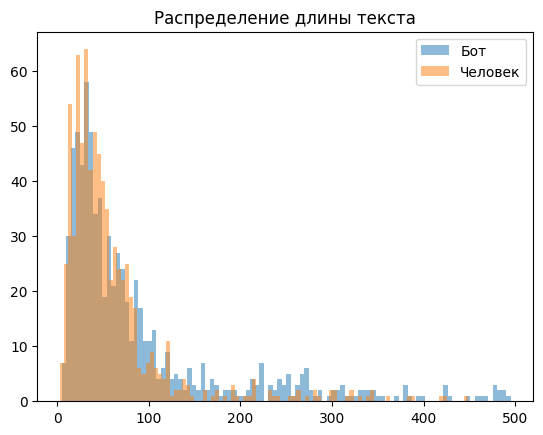

In [14]:
data_clean["text_length"] = data_clean["text"].apply(len)
data_clean["word_count"] = data_clean["text"].apply(lambda x: len(x.split()))

plt.hist(data_clean[data_clean["is_bot"] == 1]["text_length"], alpha=0.5, label="Бот", bins=100)
plt.hist(data_clean[data_clean["is_bot"] == 0]["text_length"], alpha=0.5, label="Человек", bins=100)
plt.legend()
plt.title("Распределение длины текста")
plt.show()

In [15]:
print("Размер датасета:", data_clean.shape)
print("Распределение меток:\n", data_clean["is_bot"].value_counts())
print("Пропуски:\n", data_clean.isnull().sum())
print("Дубликаты:", data_clean.duplicated().sum())

Размер датасета: (1513, 4)
Распределение меток:
 is_bot
0    769
1    744
Name: count, dtype: int64
Пропуски:
 text           0
is_bot         0
text_length    0
word_count     0
dtype: int64
Дубликаты: 6


In [16]:
duplicate_texts = data_clean[data_clean.duplicated(subset=["text"], keep=False)]
print("Конфликтующие метки для одинаковых текстов:\n", duplicate_texts.sort_values("text"))

Конфликтующие метки для одинаковых текстов:
                                                    text  is_bot  text_length  \
1151  123 123 всмы ты бот бООООТ 9вфлцфщвшфв9 фоцвфл...       1           68   
1150  123 123 всмы ты бот бООООТ 9вфлцфщвшфв9 фоцвфл...       0           68   
120   <bos> как день? как  <eos> <bos> как день? как...       0           54   
121   <bos> как день? как  <eos> <bos> как день? как...       1           54   
245                         Hi How are you? ? /// govno       1           27   
...                                                 ...     ...          ...   
1010  что такое философия? что такое философия?\n\n\...       0           51   
677         把这几个字摹下来.  把这几个字摹下来.  把这几个字摹下来.  把这几个字摹下来.        1           43   
676         把这几个字摹下来.  把这几个字摹下来.  把这几个字摹下来.  把这几个字摹下来.        0           43   
1399                                              🗿 😂😂😂       1            5   
60                                                🗿 😂😂😂       0            

In [17]:
data_clean = data_clean.drop_duplicates(subset=["text"])
print(f"Уникальных текстов: {len(data_clean)}")

Уникальных текстов: 1449


In [18]:
print("=== Примеры сообщений ботов (label=1):\n",
      data_clean[data_clean["is_bot"] == 1]["text"].sample(3).values)
print("\n=== Примеры сообщений людей (label=0):\n",
      data_clean[data_clean["is_bot"] == 0]["text"].sample(3).values)

=== Примеры сообщений ботов (label=1):
 ['Хаю хай Сижу, пишу Буквы'
 'опа человек опа человек нет а ты бот? опа человек опа человек'
 'Чё, угоняем? 😄 Блин, зае...й! Чё тебе надо? Опять? Ну и чё теперь? Не пали, брат! 😜 Ты замкнулся, да? 😂 Круто, ты мастер клавиатуры! 🤪 Тогда чё? 🤔 Скучно, да? 😒']

=== Примеры сообщений людей (label=0):
 ['🇬🇳 🇬🇳 🇬🇳 🇬🇳 🇬🇳 ййцукйцук нет ниче' 'привет  я бот'
 'знаешь историю про цыган? хочу историю про 14 вас и 88 цыган? ну история про это самое']


In [19]:
print("Размер датасета:", data_clean.shape)
print("Распределение меток:\n", data_clean["is_bot"].value_counts())
print("Пропуски:\n", data_clean.isnull().sum())
print("Дубликаты:", data_clean.duplicated().sum())

Размер датасета: (1449, 4)
Распределение меток:
 is_bot
0    761
1    688
Name: count, dtype: int64
Пропуски:
 text           0
is_bot         0
text_length    0
word_count     0
dtype: int64
Дубликаты: 0


In [20]:
train_data, test_data = train_test_split(data_clean, test_size=0.2)
test_data

,text,is_bot,text_length,word_count
1327,Привет! Чем могу помочь? 2 + 2 = 4\n,1,35,9
382,дурак кто такой файл Джордан? чей сын чай будет?,0,49,9
1564,hi what is up?,0,14,4
731,hihi hihi hihihihihihi,1,22,3
1292,материться умеешь? через жепу,0,29,4
...,...,...,...,...
1296,"yo намальна, ты как а ты веришь в Аллаха? так ...",0,67,14
593,"Извините, я не совсем понял ваш вопрос. Могли ...",1,321,55
1554,норм спасибо\nкак сам прив я миша\nа ты угу че...,1,54,14
501,"24 часа. да ну, куда я педант может быть мне э...",1,60,13


In [21]:
tokenizer = transformers.AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [22]:
train_task = tokenizer(train_data["text"].to_list(), padding=True,
                             truncation=True, max_length=512, return_tensors="pt")

test_task = tokenizer(test_data["text"].to_list(), padding=True,
                            truncation=True, max_length=512, return_tensors="pt")

In [23]:
train_dataset = TensorDataset(train_task["input_ids"],
                                 train_task["attention_mask"],
                                 train_task["token_type_ids"],
                                 torch.tensor(train_data["is_bot"].values)
                                 )

test_dataset = TensorDataset(test_task["input_ids"],
                                test_task["attention_mask"],
                                test_task["token_type_ids"],
                                torch.tensor(test_data["is_bot"].values)
                                )

In [24]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [25]:
class TransformerClassificationModel(nn.Module):
    def __init__(
          self,
          base_transformer_model: Union[str, nn.Module],
          num_classes: int
        ):
        super().__init__()
        self.backbone = transformers.AutoModel.from_pretrained(base_transformer_model)
        config = transformers.AutoConfig.from_pretrained(base_transformer_model)

        self.hidden_size = config.hidden_size

        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        self.classifier = nn.Linear(self.hidden_size, num_classes)

    def forward(
          self,
          input_ids,
          attention_mask=None,
          token_type_ids=None
        ) -> Dict[str, torch.Tensor]:

        outputs = self.backbone(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        pooled_output = outputs.last_hidden_state[:, 0, :]

        pooled_output = self.dropout(pooled_output)

        logits = self.classifier(pooled_output)

        return {'logits': logits}

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
def train_transformer(transformer_model, train_loader, test_loader, epochs=5):
    model = transformer_model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

    losses = []
    accuracy = []
    for epoch in range(epochs):
        model.train()
        losses_per_epoch = []
        for batch in tqdm(train_loader, desc=f"Training {epoch+1} epoch"):
            optimizer.zero_grad()
            input_ids, attention_mask, token_type_ids, label = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            label = label.to(device).float()

            outputs = model(input_ids,
                          attention_mask=attention_mask,
                          token_type_ids=token_type_ids)

            logits = outputs["logits"].squeeze(-1)
            loss = criterion(logits, label)
            loss.backward()
            optimizer.step()
            losses_per_epoch.append(loss.item())

        losses.append(np.mean(losses_per_epoch))

        model.eval()
        test_acc = 0
        with torch.no_grad():
            for batch in test_loader:
                input_ids, attention_mask, token_type_ids, label = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                token_type_ids = token_type_ids.to(device)
                label = label.to(device).float()

                outputs = model(input_ids,
                              attention_mask=attention_mask,
                              token_type_ids=token_type_ids)

                preds = (torch.sigmoid(outputs["logits"].squeeze(-1)) > 0.5).long()
                test_acc += (preds == label.long()).float().mean().item()

        test_acc /= len(test_loader)
        accuracy.append(test_acc)
        print(f"Epoch {epoch+1}: Train Loss = {losses[-1]:.4f}, Test Acc = {accuracy[-1]:.4f}")

    return model, losses, accuracy

In [28]:
transformer_model = TransformerClassificationModel("cointegrated/rubert-tiny2",
                                                    num_classes=1)
transformer_model_finetuned = train_transformer(transformer_model=transformer_model,
                                                                train_loader=train_dataloader,
                                                                test_loader=test_dataloader,
                                                                epochs=10)

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Training 1 epoch: 100%|██████████| 37/37 [00:04<00:00,  8.67it/s]


Epoch 1: Train Loss = 0.6857, Test Acc = 0.6500


Training 2 epoch: 100%|██████████| 37/37 [00:03<00:00, 11.82it/s]


Epoch 2: Train Loss = 0.6609, Test Acc = 0.6813


Training 3 epoch: 100%|██████████| 37/37 [00:03<00:00, 11.77it/s]


Epoch 3: Train Loss = 0.6500, Test Acc = 0.6781


Training 4 epoch: 100%|██████████| 37/37 [00:03<00:00, 11.81it/s]


Epoch 4: Train Loss = 0.6310, Test Acc = 0.6906


Training 5 epoch: 100%|██████████| 37/37 [00:03<00:00, 11.80it/s]


Epoch 5: Train Loss = 0.6109, Test Acc = 0.7000


Training 6 epoch: 100%|██████████| 37/37 [00:03<00:00, 11.76it/s]


Epoch 6: Train Loss = 0.5979, Test Acc = 0.7031


Training 7 epoch: 100%|██████████| 37/37 [00:03<00:00, 11.74it/s]


Epoch 7: Train Loss = 0.5766, Test Acc = 0.7094


Training 8 epoch: 100%|██████████| 37/37 [00:03<00:00, 11.75it/s]


Epoch 8: Train Loss = 0.5628, Test Acc = 0.7031


Training 9 epoch: 100%|██████████| 37/37 [00:03<00:00, 11.73it/s]


Epoch 9: Train Loss = 0.5500, Test Acc = 0.7000


Training 10 epoch: 100%|██████████| 37/37 [00:03<00:00, 11.65it/s]

Epoch 10: Train Loss = 0.5418, Test Acc = 0.6969


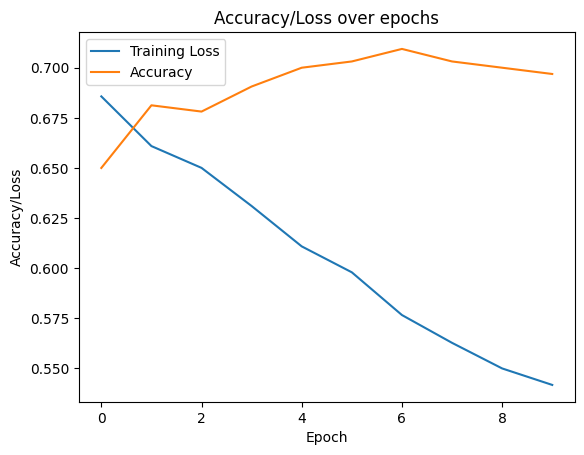

In [29]:
plt.plot(transformer_model_finetuned[1], label='Training Loss')
plt.plot(transformer_model_finetuned[2], label='Accuracy')
plt.title('Accuracy/Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend()

In [30]:
def predict_proba(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = transformer_model_finetuned[0](**inputs)
    logits = outputs['logits']
    probas = torch.sigmoid(logits).cpu().numpy()
    return probas[:, 0]

text = "Hello! Отлично! А твои? Расскажи теорему"
bot_prob = predict_proba([text])[0]
print(f"Текст: '{text}'\nВероятность бота: {bot_prob:.4f}")

Текст: 'Hello! Отлично! А твои? Расскажи теорему'
Вероятность бота: 0.1471


In [31]:
X_test = df_test["text"]
lst = X_test.tolist()
proba = []
for i in lst:
    proba.append(predict_proba(i)[0])

preds_df = pd.DataFrame({"ID": df_test["ID"], "is_bot": proba})
preds_df.to_csv("preds.csv", index=False)

#Вывод
Получилось поработать с fine-tune моделей.

За основу экспериментов был взят очевидно BERT, для экспериментов использовал: cointegrated/rubert-tiny2, rubert-base-cased, DeepPavlov/rubert-base-cased, ai-forever/ruBert-large

Практически все модели выдавали +- одинаковое acc (0.65), лучшая модель оказалась cointegrated/rubert-tiny2, которая выдала качество 0.7

После ряда эксперминетов я убедился, что в данной задаче самое сложное - это обработать данные, потому что данные в датасете очень специфичные. Постарался качественно обработать датасет, убрал дубликаты, убрал шум (текст на 22000 символов) и добился увеличения качества.